<a href="https://colab.research.google.com/github/Asmina-hub/AGI_Project/blob/main/Liner_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch gcsfs
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import gcsfs
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_RGB = 3
BATCH_SIZE = 16
CLASS_NAMES=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
CLASS_INDEX = {name:i for i,name in enumerate(CLASS_NAMES)}

In [32]:
#cutom class in pytorch to load the dataset
class FlowerDataSet(Dataset):
  def __init__(self,csv_file_path,transform=None):
    # Use gcsfs to open the file from GCS
    self.fs = gcsfs.GCSFileSystem()
    with self.fs.open(csv_file_path, 'rb') as f:
      self.data=pd.read_csv(f,header=None, names=['filename','label'])
    self.transform=transform
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,index):
    image_path=self.data.iloc[index,0]
    label_str = self.data.iloc[index,1]
    # Use gcsfs to open the image file
    with self.fs.open(image_path, 'rb') as f:
      image=Image.open(f).convert( 'RGB')

    if self.transform:
      image=self.transform(image)
    label = CLASS_INDEX[label_str]

    return image,label

In [33]:
transform = transforms.Compose([transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),transforms.ToTensor()])

In [34]:
train_dataset = FlowerDataSet("gs://cloud-ml-data/img/flower_photos/train_set.csv",
                              transform=transform )
test_dataset = FlowerDataSet("gs://cloud-ml-data/img/flower_photos/eval_set.csv",
                              transform=transform)

In [40]:
train_dataset.data.head()

,filename,label
0,gs://cloud-ml-data/img/flower_photos/daisy/754...,daisy
1,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
2,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
3,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
4,gs://cloud-ml-data/img/flower_photos/daisy/406...,daisy


In [41]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [45]:
for imagebatch , labelbatch in train_loader:
  print(imagebatch.shape)
  print(labelbatch.shape)
  print("Labels:", labelbatch.numpy())
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])
Labels: [0 2 1 1 1 3 1 3 3 3 2 0 2 1 1 0]


torch.Size([16, 3, 224, 224])
torch.Size([16])


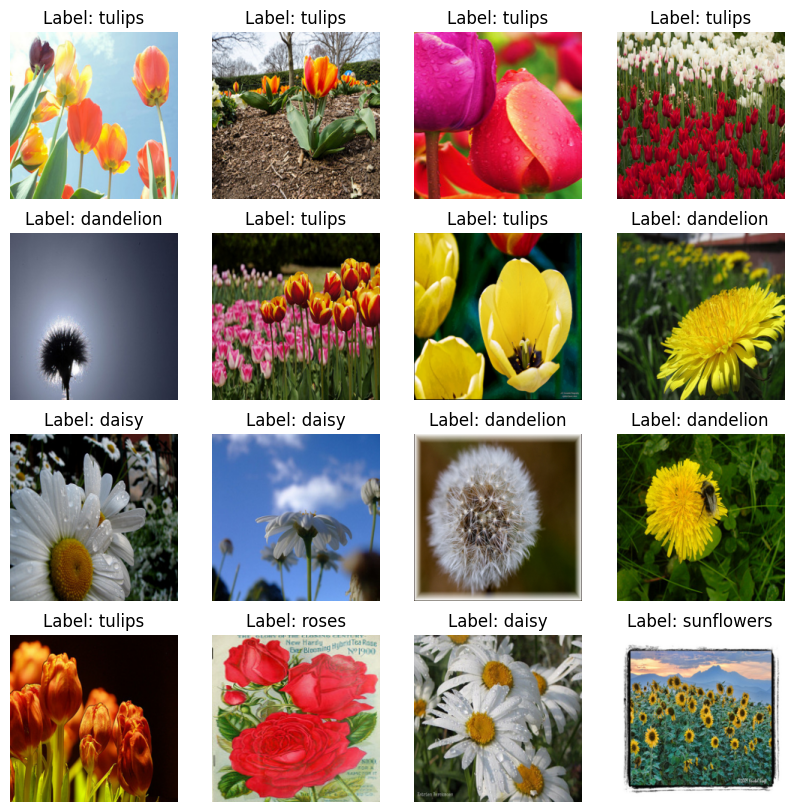

In [58]:
data_iterator=iter(train_loader)
images,labels=next(data_iterator)
print(images.shape)
print(labels.shape)
for image_batch, label_batch in data_iterator:
    fig,axs = plt.subplots(4,4, figsize=(10,10))
    for i in range(16):
      axs[i//4, i%4].imshow(image_batch[i].permute(1, 2, 0).numpy())
      axs[i//4, i%4].set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
      axs[i//4, i%4].axis('off')
    plt.show()
    break
